# Notebook structure:
* Categories distribution
* CountVectorizer + LogReg + TfidfVectorizer training with unbalanced dataset
* Balancing dataset
* Training LogReg & GB with Tfidf & CountVectorizer on balanced dataset
* Feature importances + greater&smaller weights
* Trying word2vec + training models

**Dataset:** Top 100 films + low-rating films

**Dataset shape:** 60058∗2

Reviews: reviews without nltk.stopwords, without tags, with lemmatization

In [1]:
%cd ../..

from datasets.getters import  load_reviews_Review_Label_clean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dill

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.linear_model import LogisticRegression 
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer, WhitespaceTokenizer
import nltk
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingClassifier
import catboost as cb
from gensim.models import Word2Vec

from pprint import pprint

from pymystem3 import Mystem

np.set_printoptions(threshold=np.inf)

C:\Users\Yaroslav Pristalov\Documents\Programming\nlp-coursework


data.shape=(90646, 2)
POSITIVE    69219
NEUTRAL     11579
NEGATIVE     9848
Name: label, dtype: int64


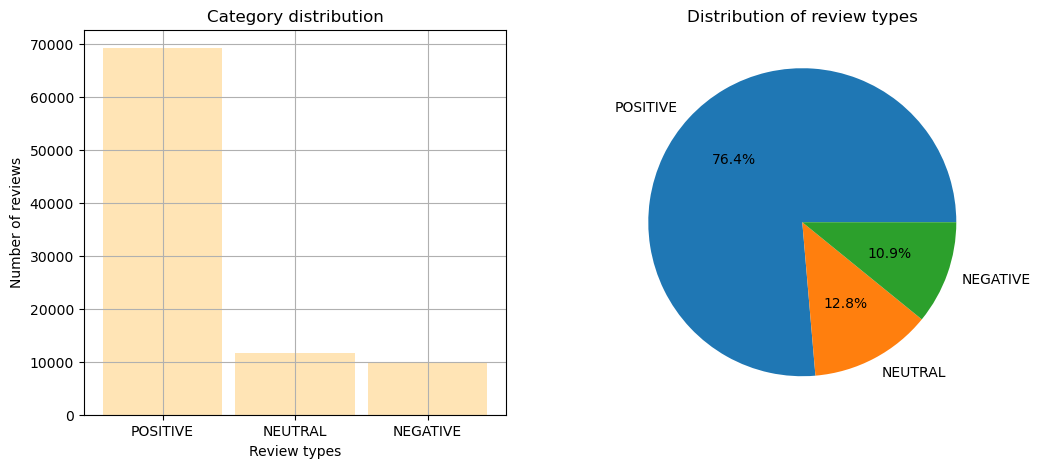

(55346, 2) (23721, 2)


,review,label
54700,фильм стоить выходить предел великобритания . ...,0
67873,это самый впечатляющий по-настоящему жуткий фи...,2
44030,первый часть ' чужой ' свой время произвести в...,2
21503,история начинающий барабанщик эндрю зародиться...,2
75163,< b > дождаться . прокат выйти новый кинолента...,2
...,...,...
6265,"весь равный мера свойственно злорадствовать , ...",0
54886,"неординарный фильм . , уверить — книга всё чёт...",2
76820,"сильно заинтересованный ' дэдпул ' , однако уз...",2
860,"фильм , который неизменно занимать первый мест...",2


In [2]:
# Open dataset
with open('reviews_Review_Label_razdel_nltk.df', 'rb') as f:
    data = dill.load(f)
print(f'{data.shape=}')
print(data.label.value_counts())

# Basic visual
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].bar(data.label.value_counts().index, 
       data.label.value_counts().values, 
       color = 'moccasin', width = 0.9)
ax[0].set_title("Category distribution")
ax[0].set_xlabel("Review types")
ax[0].set_ylabel("Number of reviews")
ax[0].grid(True)

ax[1].pie(data.label.value_counts(), labels=data.label.value_counts().index, autopct='%1.1f%%')
ax[1].set_title('Distribution of review types')

plt.show()

# Basic preprocessing
label_encoding = {
    'POSITIVE': 2,
    'NEUTRAL': 1,
    'NEGATIVE': 0
}

data.label = data.label.apply(lambda label: label_encoding[label])
data = data[data.label != 1].reset_index().drop(columns=['index'])
train, test = train_test_split(data, test_size=0.3, random_state=42)

print(train.shape, test.shape)
train

---

In [3]:
for _tokenizer in ['razdel', 'TreebankWordTokenizer', 'rutokenizer']:
    for i, _stopwords in enumerate(['fictitious', 'stopwords', 'list']):        
        i_to_sw_name = {0: 'nltk', 1: 'spacy', 2: 'third_party_nltk'}
        
        with open(f'reviews_Review_Label_{_tokenizer}_{i_to_sw_name[i]}.df', 'rb') as file:
            data = dill.load(file)
            print(f"Data was loaded from '{file.name}'")
        
        print(f'{_tokenizer=}, stopwords={i_to_sw_name[i]}')
        print(f'{data.shape=}\n')
        
        # Basic preprocessing
        label_encoding = {
            'POSITIVE': 2,
            'NEUTRAL': 1,
            'NEGATIVE': 0
        }

        data.label = data.label.apply(lambda label: label_encoding[label])
        data = data[data.label != 1].reset_index().drop(columns=['index'])
        train, test = train_test_split(data, test_size=0.3, random_state=42)

        
        print('CountVectorizer:')
        cnt_vec = CountVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
        X_train = cnt_vec.fit_transform(train.review)
        X_test  = cnt_vec.transform(test.review)

        clf = LogisticRegression(max_iter=200, n_jobs=-1)
        clf.fit(X_train, train.label)
        pred = clf.predict(X_test)

        print(classification_report(test.label, pred))
        
        
        print('\nTfidfVectorizer:')
        cnt_vec = TfidfVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
        X_train = cnt_vec.fit_transform(train.review)
        X_test  = cnt_vec.transform(test.review)

        clf = LogisticRegression(max_iter=200, n_jobs=-1)
        clf.fit(X_train, train.label)
        pred = clf.predict(X_test)

        print(classification_report(test.label, pred))
        
        print('\n---------------------------------------------------------------\n')

Data was loaded from 'reviews_Review_Label_razdel_nltk.df'
_tokenizer='razdel', stopwords=nltk
data.shape=(90646, 2)

CountVectorizer:
              precision    recall  f1-score   support

           0       0.81      0.76      0.78      2979
           2       0.97      0.98      0.97     20742

    accuracy                           0.95     23721
   macro avg       0.89      0.87      0.88     23721
weighted avg       0.95      0.95      0.95     23721


TfidfVectorizer:
              precision    recall  f1-score   support

           0       0.91      0.55      0.69      2979
           2       0.94      0.99      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.93      0.77      0.83     23721
weighted avg       0.94      0.94      0.93     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_razdel_spacy.df'
_tokenizer='razdel', stopwords=spacy
data.shape=(90646, 2)

CountVe

In [4]:
for _tokenizer in ['razdel', 'TreebankWordTokenizer', 'rutokenizer']:
    for i, _stopwords in enumerate(['fictitious', 'stopwords', 'list']):        
        i_to_sw_name = {0: 'nltk', 1: 'spacy', 2: 'third_party_nltk'}
        
        with open(f'reviews_Review_Label_{_tokenizer}_{i_to_sw_name[i]}.df', 'rb') as file:
            data = dill.load(file)
            print(f"Data was loaded from '{file.name}'")
        
        print(f'{_tokenizer=}, stopwords={i_to_sw_name[i]}')
        print(f'{data.shape=}\n')
        
        
        # Basic preprocessing
        label_encoding = {
            'POSITIVE': 2,
            'NEUTRAL': 1,
            'NEGATIVE': 0
        }

        data.label = data.label.apply(lambda label: label_encoding[label])
        data = data[data.label != 1].reset_index().drop(columns=['index'])
        train, test = train_test_split(data, test_size=0.3, random_state=42)
        
        
        print('CountVectorizer:')
        cnt_vec = CountVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
        X_train = cnt_vec.fit_transform(train.review)
        X_test  = cnt_vec.transform(test.review)

        clf = LogisticRegression(max_iter=200, n_jobs=-1, class_weight='balanced')
        clf.fit(X_train, train.label)
        pred = clf.predict(X_test)

        print(classification_report(test.label, pred))
        
        
        print('\nTfidfVectorizer:')
        cnt_vec = TfidfVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
        X_train = cnt_vec.fit_transform(train.review)
        X_test  = cnt_vec.transform(test.review)

        clf = LogisticRegression(max_iter=200, n_jobs=-1, class_weight='balanced')
        clf.fit(X_train, train.label)
        pred = clf.predict(X_test)

        print(classification_report(test.label, pred))
        
        print('\n---------------------------------------------------------------\n')

Data was loaded from 'reviews_Review_Label_razdel_nltk.df'
_tokenizer='razdel', stopwords=nltk
data.shape=(90646, 2)

CountVectorizer:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79      2979
           2       0.98      0.96      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.86      0.89      0.88     23721
weighted avg       0.95      0.94      0.94     23721


TfidfVectorizer:
              precision    recall  f1-score   support

           0       0.67      0.90      0.77      2979
           2       0.99      0.94      0.96     20742

    accuracy                           0.93     23721
   macro avg       0.83      0.92      0.86     23721
weighted avg       0.95      0.93      0.94     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_razdel_spacy.df'
_tokenizer='razdel', stopwords=spacy
data.shape=(90646, 2)

CountVe

In [5]:
for _tokenizer in ['razdel', 'TreebankWordTokenizer', 'rutokenizer']:
    for i, _stopwords in enumerate(['fictitious', 'stopwords', 'list']):        
        i_to_sw_name = {0: 'nltk', 1: 'spacy', 2: 'third_party_nltk'}
        
        with open(f'reviews_Review_Label_{_tokenizer}_{i_to_sw_name[i]}.df', 'rb') as file:
            data = dill.load(file)
            print(f"Data was loaded from '{file.name}'")
        
        print(f'{_tokenizer=}, stopwords={i_to_sw_name[i]}')
        print(f'{data.shape=}\n')
        
        
        # Basic preprocessing
        label_encoding = {
            'POSITIVE': 2,
            'NEUTRAL': 1,
            'NEGATIVE': 0
        }

        data.label = data.label.apply(lambda label: label_encoding[label])
        data = data[data.label != 1].reset_index().drop(columns=['index'])
        train, test = train_test_split(data, test_size=0.3, random_state=42)
        
        
        print('CountVectorizer:')
        cnt_vec = CountVectorizer(tokenizer=WhitespaceTokenizer().tokenize, max_df=0.6, max_features=10000)
        X_train = cnt_vec.fit_transform(train.review)
        X_test  = cnt_vec.transform(test.review)

        clf = LogisticRegression(max_iter=200, n_jobs=-1, class_weight='balanced')
        clf.fit(X_train, train.label)
        pred = clf.predict(X_test)

        print(classification_report(test.label, pred))
        
        
        print('\nTfidfVectorizer:')
        cnt_vec = TfidfVectorizer(tokenizer=WhitespaceTokenizer().tokenize, max_df=0.6, max_features=10000)
        X_train = cnt_vec.fit_transform(train.review)
        X_test  = cnt_vec.transform(test.review)

        clf = LogisticRegression(max_iter=200, n_jobs=-1, class_weight='balanced')
        clf.fit(X_train, train.label)
        pred = clf.predict(X_test)

        print(classification_report(test.label, pred))
        
        print('\n---------------------------------------------------------------\n')

Data was loaded from 'reviews_Review_Label_razdel_nltk.df'
_tokenizer='razdel', stopwords=nltk
data.shape=(90646, 2)

CountVectorizer:
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      2979
           2       0.97      0.96      0.96     20742

    accuracy                           0.94     23721
   macro avg       0.85      0.88      0.86     23721
weighted avg       0.94      0.94      0.94     23721


TfidfVectorizer:
              precision    recall  f1-score   support

           0       0.67      0.90      0.76      2979
           2       0.98      0.94      0.96     20742

    accuracy                           0.93     23721
   macro avg       0.83      0.92      0.86     23721
weighted avg       0.94      0.93      0.93     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_razdel_spacy.df'
_tokenizer='razdel', stopwords=spacy
data.shape=(90646, 2)

CountVe

In [6]:
for _tokenizer in ['razdel', 'TreebankWordTokenizer', 'rutokenizer']:
    for i, _stopwords in enumerate(['fictitious', 'stopwords', 'list']):        
        i_to_sw_name = {0: 'nltk', 1: 'spacy', 2: 'third_party_nltk'}
        
        with open(f'reviews_Review_Label_{_tokenizer}_{i_to_sw_name[i]}.df', 'rb') as file:
            data = dill.load(file)
            print(f"Data was loaded from '{file.name}'")
        
        print(f'{_tokenizer=}, stopwords={i_to_sw_name[i]}')
        print(f'{data.shape=}\n')
        
        
        # Basic preprocessing
        label_encoding = {
            'POSITIVE': 2,
            'NEUTRAL': 1,
            'NEGATIVE': 0
        }

        data.label = data.label.apply(lambda label: label_encoding[label])
        data = data[data.label != 1].reset_index().drop(columns=['index'])
        train, test = train_test_split(data, test_size=0.3, random_state=42)
        
        
        print('CountVectorizer:')
        cnt_vec = CountVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
        X_train = cnt_vec.fit_transform(train.review)
        X_test  = cnt_vec.transform(test.review)

        clf = LogisticRegression(max_iter=3000, n_jobs=-1, class_weight='balanced', solver='saga')
        clf.fit(X_train, train.label)
        pred = clf.predict(X_test)

        print(classification_report(test.label, pred))
        
        
        print('\nTfidfVectorizer:')
        cnt_vec = TfidfVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
        X_train = cnt_vec.fit_transform(train.review)
        X_test  = cnt_vec.transform(test.review)

        clf = LogisticRegression(max_iter=200, n_jobs=-1, class_weight='balanced', solver='saga')
        clf.fit(X_train, train.label)
        pred = clf.predict(X_test)

        print(classification_report(test.label, pred))
        
        print('\n---------------------------------------------------------------\n')

Data was loaded from 'reviews_Review_Label_razdel_nltk.df'
_tokenizer='razdel', stopwords=nltk
data.shape=(90646, 2)

CountVectorizer:
              precision    recall  f1-score   support

           0       0.71      0.88      0.79      2979
           2       0.98      0.95      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.85      0.92      0.88     23721
weighted avg       0.95      0.94      0.94     23721


TfidfVectorizer:
              precision    recall  f1-score   support

           0       0.67      0.90      0.77      2979
           2       0.99      0.94      0.96     20742

    accuracy                           0.93     23721
   macro avg       0.83      0.92      0.86     23721
weighted avg       0.95      0.93      0.94     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_razdel_spacy.df'
_tokenizer='razdel', stopwords=spacy
data.shape=(90646, 2)

CountVe

In [7]:
for _tokenizer in ['razdel', 'TreebankWordTokenizer', 'rutokenizer']:
    for i, _stopwords in enumerate(['fictitious', 'stopwords', 'list']):        
        i_to_sw_name = {0: 'nltk', 1: 'spacy', 2: 'third_party_nltk'}
        
        with open(f'reviews_Review_Label_{_tokenizer}_{i_to_sw_name[i]}.df', 'rb') as file:
            data = dill.load(file)
            print(f"Data was loaded from '{file.name}'")
        
        print(f'{_tokenizer=}, stopwords={i_to_sw_name[i]}')
        print(f'{data.shape=}\n')
        
        
        # Basic preprocessing
        label_encoding = {
            'POSITIVE': 2,
            'NEUTRAL': 1,
            'NEGATIVE': 0
        }

        data.label = data.label.apply(lambda label: label_encoding[label])
        data = data[data.label != 1].reset_index().drop(columns=['index'])
        train, test = train_test_split(data, test_size=0.3, random_state=42)
        
        
        print('CountVectorizer:')
        cnt_vec = CountVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
        X_train = cnt_vec.fit_transform(train.review)
        X_test  = cnt_vec.transform(test.review)

        clf = LogisticRegression(max_iter=200, n_jobs=-1, solver='liblinear')
        clf.fit(X_train, train.label)
        pred = clf.predict(X_test)

        print(classification_report(test.label, pred))
        
        
        print('\nTfidfVectorizer:')
        cnt_vec = TfidfVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
        X_train = cnt_vec.fit_transform(train.review)
        X_test  = cnt_vec.transform(test.review)

        clf = LogisticRegression(max_iter=200, n_jobs=-1, solver='liblinear')
        clf.fit(X_train, train.label)
        pred = clf.predict(X_test)

        print(classification_report(test.label, pred))
        
        print('\n---------------------------------------------------------------\n')

Data was loaded from 'reviews_Review_Label_razdel_nltk.df'
_tokenizer='razdel', stopwords=nltk
data.shape=(90646, 2)

CountVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.81      0.75      0.78      2979
           2       0.96      0.97      0.97     20742

    accuracy                           0.95     23721
   macro avg       0.89      0.86      0.87     23721
weighted avg       0.94      0.95      0.95     23721


TfidfVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.91      0.55      0.69      2979
           2       0.94      0.99      0.96     20742

    accuracy                           0.94     23721
   macro avg       0.92      0.77      0.83     23721
weighted avg       0.94      0.94      0.93     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_razdel_spacy.df'
_tokenizer='razdel', stopwords=spacy
data.shape=(90646, 2)

CountVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.80      0.74      0.77      2979
           2       0.96      0.97      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.88      0.86      0.87     23721
weighted avg       0.94      0.94      0.94     23721


TfidfVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.91      0.53      0.67      2979
           2       0.94      0.99      0.96     20742

    accuracy                           0.93     23721
   macro avg       0.92      0.76      0.82     23721
weighted avg       0.93      0.93      0.93     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_razdel_third_party_nltk.df'
_tokenizer='razdel', stopwords=third_party_nltk
data.shape=(90646, 2)

CountVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.81      0.75      0.78      2979
           2       0.96      0.97      0.97     20742

    accuracy                           0.95     23721
   macro avg       0.89      0.86      0.87     23721
weighted avg       0.94      0.95      0.95     23721


TfidfVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.91      0.54      0.68      2979
           2       0.94      0.99      0.96     20742

    accuracy                           0.94     23721
   macro avg       0.92      0.77      0.82     23721
weighted avg       0.93      0.94      0.93     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_TreebankWordTokenizer_nltk.df'
_tokenizer='TreebankWordTokenizer', stopwords=nltk
data.shape=(90646, 2)

CountVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.81      0.70      0.75      2979
           2       0.96      0.98      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.89      0.84      0.86     23721
weighted avg       0.94      0.94      0.94     23721


TfidfVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.90      0.50      0.64      2979
           2       0.93      0.99      0.96     20742

    accuracy                           0.93     23721
   macro avg       0.91      0.75      0.80     23721
weighted avg       0.93      0.93      0.92     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_TreebankWordTokenizer_spacy.df'
_tokenizer='TreebankWordTokenizer', stopwords=spacy
data.shape=(90646, 2)

CountVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.80      0.68      0.73      2979
           2       0.95      0.98      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.88      0.83      0.85     23721
weighted avg       0.94      0.94      0.94     23721


TfidfVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.90      0.46      0.61      2979
           2       0.93      0.99      0.96     20742

    accuracy                           0.93     23721
   macro avg       0.91      0.72      0.78     23721
weighted avg       0.92      0.93      0.91     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_TreebankWordTokenizer_third_party_nltk.df'
_tokenizer='TreebankWordTokenizer', stopwords=third_party_nltk
data.shape=(90646, 2)

CountVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.81      0.69      0.74      2979
           2       0.96      0.98      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.88      0.83      0.85     23721
weighted avg       0.94      0.94      0.94     23721


TfidfVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.90      0.48      0.62      2979
           2       0.93      0.99      0.96     20742

    accuracy                           0.93     23721
   macro avg       0.91      0.73      0.79     23721
weighted avg       0.93      0.93      0.92     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_rutokenizer_nltk.df'
_tokenizer='rutokenizer', stopwords=nltk
data.shape=(90646, 2)

CountVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.80      0.74      0.77      2979
           2       0.96      0.97      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.88      0.86      0.87     23721
weighted avg       0.94      0.94      0.94     23721


TfidfVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.91      0.55      0.69      2979
           2       0.94      0.99      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.93      0.77      0.83     23721
weighted avg       0.94      0.94      0.93     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_rutokenizer_spacy.df'
_tokenizer='rutokenizer', stopwords=spacy
data.shape=(90646, 2)

CountVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.81      0.73      0.77      2979
           2       0.96      0.98      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.89      0.85      0.87     23721
weighted avg       0.94      0.94      0.94     23721


TfidfVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.91      0.52      0.67      2979
           2       0.94      0.99      0.96     20742

    accuracy                           0.93     23721
   macro avg       0.93      0.76      0.81     23721
weighted avg       0.93      0.93      0.93     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_rutokenizer_third_party_nltk.df'
_tokenizer='rutokenizer', stopwords=third_party_nltk
data.shape=(90646, 2)

CountVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.81      0.74      0.77      2979
           2       0.96      0.97      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.88      0.86      0.87     23721
weighted avg       0.94      0.94      0.94     23721


TfidfVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.91      0.54      0.67      2979
           2       0.94      0.99      0.96     20742

    accuracy                           0.94     23721
   macro avg       0.92      0.76      0.82     23721
weighted avg       0.93      0.94      0.93     23721


---------------------------------------------------------------



#### Balancing dataset

[SMOTE: метод увеличения числа примеров миноритарного класса](https://medium.com/nuances-of-programming/smote-%D0%BC%D0%B5%D1%82%D0%BE%D0%B4-%D1%83%D0%B2%D0%B5%D0%BB%D0%B8%D1%87%D0%B5%D0%BD%D0%B8%D1%8F-%D1%87%D0%B8%D1%81%D0%BB%D0%B0-%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80%D0%BE%D0%B2-%D0%BC%D0%B8%D0%BD%D0%BE%D1%80%D0%B8%D1%82%D0%B0%D1%80%D0%BD%D0%BE%D0%B3%D0%BE-%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B0-da91a62f9914)
> Другим вариантом является увеличение примеров миноритарного класса. Иными словами, случайным образом дублируются образцы миноритарного класса. Проблема этого подхода заключается в том, что он приводит к чрезмерному обучению, поскольку модель обучается на одних и тех же примерах.

In [6]:
train.label.value_counts()

2    48477
0     6869
Name: label, dtype: int64

In [9]:
train = pd.concat([train, resample(train[train.label == 0], n_samples=41500, random_state=42)])
train

,review,label
54700,фильм стоить выходить предел великобритания . ...,0
67873,это самый впечатляющий по-настоящему жуткий фи...,2
44030,первый часть ' чужой ' свой время произвести в...,2
21503,история начинающий барабанщик эндрю зародиться...,2
75163,< b > дождаться . прокат выйти новый кинолента...,2
...,...,...
59219,< i > - хотеть нормальный ? наоборот . < / i >...,0
70598,"фильм однозначный , отношение двоякий . нарком...",0
6477,", прийти пора пропеть очередной песня славный ...",0
58139,"начать , пожалуй , , фильм пойти , прочитать к...",0


In [10]:
train.label.value_counts()

2    48477
0    48369
Name: label, dtype: int64

---

In [8]:
for _tokenizer in ['razdel', 'TreebankWordTokenizer', 'rutokenizer']:
    for i, _stopwords in enumerate(['fictitious', 'stopwords', 'list']):        
        i_to_sw_name = {0: 'nltk', 1: 'spacy', 2: 'third_party_nltk'}
        
        with open(f'reviews_Review_Label_{_tokenizer}_{i_to_sw_name[i]}.df', 'rb') as file:
            data = dill.load(file)
            print(f"Data was loaded from '{file.name}'")
        
        print(f'{_tokenizer=}, stopwords={i_to_sw_name[i]}')
        print(f'{data.shape=}\n')
        
        
        # Basic preprocessing
        label_encoding = {
            'POSITIVE': 2,
            'NEUTRAL': 1,
            'NEGATIVE': 0
        }

        data.label = data.label.apply(lambda label: label_encoding[label])
        data = data[data.label != 1].reset_index().drop(columns=['index'])
        train, test = train_test_split(data, test_size=0.3, random_state=42)
                                       
        train = pd.concat([train, resample(train[train.label == 0], n_samples=41500, random_state=42)])
        print(f'{train.shape=}')
        
        
        print('CountVectorizer:')
        cnt_vec = CountVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
        X_train = cnt_vec.fit_transform(train.review)
        X_test  = cnt_vec.transform(test.review)

        clf = LogisticRegression(max_iter=200, n_jobs=-1)
        clf.fit(X_train, train.label)
        pred = clf.predict(X_test)

        print(classification_report(test.label, pred))
        
        
        print('\nTfidfVectorizer:')
        cnt_vec = TfidfVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
        X_train = cnt_vec.fit_transform(train.review)
        X_test  = cnt_vec.transform(test.review)

        clf = LogisticRegression(max_iter=200, n_jobs=-1)
        clf.fit(X_train, train.label)
        pred = clf.predict(X_test)

        print(classification_report(test.label, pred))
        
        print('\n---------------------------------------------------------------\n')

Data was loaded from 'reviews_Review_Label_razdel_nltk.df'
_tokenizer='razdel', stopwords=nltk
data.shape=(90646, 2)

train.shape=(96846, 2)
CountVectorizer:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78      2979
           2       0.97      0.96      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.86      0.89      0.87     23721
weighted avg       0.95      0.94      0.94     23721


TfidfVectorizer:
              precision    recall  f1-score   support

           0       0.69      0.90      0.78      2979
           2       0.98      0.94      0.96     20742

    accuracy                           0.94     23721
   macro avg       0.84      0.92      0.87     23721
weighted avg       0.95      0.94      0.94     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_razdel_spacy.df'
_tokenizer='razdel', stopwords=spacy
data.sh

D:\ProgramData\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.68      0.89      0.77      2979
           2       0.98      0.94      0.96     20742

    accuracy                           0.93     23721
   macro avg       0.83      0.92      0.87     23721
weighted avg       0.95      0.93      0.94     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_rutokenizer_spacy.df'
_tokenizer='rutokenizer', stopwords=spacy
data.shape=(90646, 2)

train.shape=(96846, 2)
CountVectorizer:
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      2979
           2       0.97      0.95      0.96     20742

    accuracy                           0.94     23721
   macro avg       0.85      0.88      0.86     23721
weighted avg       0.94      0.94      0.94     23721


TfidfVectorizer:
              precision    recall  f1-score   support

           0       0.68      0.89    

In [9]:
for _tokenizer in ['razdel', 'TreebankWordTokenizer', 'rutokenizer']:
    for i, _stopwords in enumerate(['fictitious', 'stopwords', 'list']):        
        i_to_sw_name = {0: 'nltk', 1: 'spacy', 2: 'third_party_nltk'}
        
        with open(f'reviews_Review_Label_{_tokenizer}_{i_to_sw_name[i]}.df', 'rb') as file:
            data = dill.load(file)
            print(f"Data was loaded from '{file.name}'")
        
        print(f'{_tokenizer=}, stopwords={i_to_sw_name[i]}')
        print(f'{data.shape=}\n')
        
        
        # Basic preprocessing
        label_encoding = {
            'POSITIVE': 2,
            'NEUTRAL': 1,
            'NEGATIVE': 0
        }

        data.label = data.label.apply(lambda label: label_encoding[label])
        data = data[data.label != 1].reset_index().drop(columns=['index'])
        train, test = train_test_split(data, test_size=0.3, random_state=42)
                                       
        train = pd.concat([train, resample(train[train.label == 0], n_samples=41500, random_state=42)])
        print(f'{train.shape=}')
        
        
        print('CountVectorizer:')
        cnt_vec = CountVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
        X_train = cnt_vec.fit_transform(train.review)
        X_test  = cnt_vec.transform(test.review)

        clf = LogisticRegression(max_iter=200, n_jobs=-1, class_weight='balanced')
        clf.fit(X_train, train.label)
        pred = clf.predict(X_test)

        print(classification_report(test.label, pred))
        
        
        print('\nTfidfVectorizer:')
        cnt_vec = TfidfVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
        X_train = cnt_vec.fit_transform(train.review)
        X_test  = cnt_vec.transform(test.review)

        clf = LogisticRegression(max_iter=200, n_jobs=-1, class_weight='balanced')
        clf.fit(X_train, train.label)
        pred = clf.predict(X_test)

        print(classification_report(test.label, pred))
        
        print('\n---------------------------------------------------------------\n')

Data was loaded from 'reviews_Review_Label_razdel_nltk.df'
_tokenizer='razdel', stopwords=nltk
data.shape=(90646, 2)

train.shape=(96846, 2)
CountVectorizer:
              precision    recall  f1-score   support

           0       0.75      0.82      0.79      2979
           2       0.97      0.96      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.86      0.89      0.88     23721
weighted avg       0.95      0.94      0.94     23721


TfidfVectorizer:
              precision    recall  f1-score   support

           0       0.69      0.90      0.78      2979
           2       0.98      0.94      0.96     20742

    accuracy                           0.94     23721
   macro avg       0.84      0.92      0.87     23721
weighted avg       0.95      0.94      0.94     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_razdel_spacy.df'
_tokenizer='razdel', stopwords=spacy
data.sh

In [10]:
for _tokenizer in ['razdel', 'TreebankWordTokenizer', 'rutokenizer']:
    for i, _stopwords in enumerate(['fictitious', 'stopwords', 'list']):        
        i_to_sw_name = {0: 'nltk', 1: 'spacy', 2: 'third_party_nltk'}
        
        with open(f'reviews_Review_Label_{_tokenizer}_{i_to_sw_name[i]}.df', 'rb') as file:
            data = dill.load(file)
            print(f"Data was loaded from '{file.name}'")
        
        print(f'{_tokenizer=}, stopwords={i_to_sw_name[i]}')
        print(f'{data.shape=}\n')
        
        
        # Basic preprocessing
        label_encoding = {
            'POSITIVE': 2,
            'NEUTRAL': 1,
            'NEGATIVE': 0
        }

        data.label = data.label.apply(lambda label: label_encoding[label])
        data = data[data.label != 1].reset_index().drop(columns=['index'])
        train, test = train_test_split(data, test_size=0.3, random_state=42)
                                       
        train = pd.concat([train, resample(train[train.label == 0], n_samples=41500, random_state=42)])
        print(f'{train.shape=}')
        
        
        print('CountVectorizer:')
        cnt_vec = CountVectorizer(tokenizer=WhitespaceTokenizer().tokenize, max_df=0.6, max_features=10000)
        X_train = cnt_vec.fit_transform(train.review)
        X_test  = cnt_vec.transform(test.review)

        clf = LogisticRegression(max_iter=200, n_jobs=-1)
        clf.fit(X_train, train.label)
        pred = clf.predict(X_test)

        print(classification_report(test.label, pred))
        
        
        print('\nTfidfVectorizer:')
        cnt_vec = TfidfVectorizer(tokenizer=WhitespaceTokenizer().tokenize, max_df=0.6, max_features=10000)
        X_train = cnt_vec.fit_transform(train.review)
        X_test  = cnt_vec.transform(test.review)

        clf = LogisticRegression(max_iter=200, n_jobs=-1)
        clf.fit(X_train, train.label)
        pred = clf.predict(X_test)

        print(classification_report(test.label, pred))
        
        print('\n---------------------------------------------------------------\n')

Data was loaded from 'reviews_Review_Label_razdel_nltk.df'
_tokenizer='razdel', stopwords=nltk
data.shape=(90646, 2)

train.shape=(96846, 2)
CountVectorizer:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      2979
           2       0.97      0.96      0.96     20742

    accuracy                           0.94     23721
   macro avg       0.85      0.87      0.86     23721
weighted avg       0.94      0.94      0.94     23721


TfidfVectorizer:
              precision    recall  f1-score   support

           0       0.68      0.89      0.77      2979
           2       0.98      0.94      0.96     20742

    accuracy                           0.93     23721
   macro avg       0.83      0.92      0.87     23721
weighted avg       0.95      0.93      0.94     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_razdel_spacy.df'
_tokenizer='razdel', stopwords=spacy
data.sh

In [11]:
for _tokenizer in ['razdel', 'TreebankWordTokenizer', 'rutokenizer']:
    for i, _stopwords in enumerate(['fictitious', 'stopwords', 'list']):        
        i_to_sw_name = {0: 'nltk', 1: 'spacy', 2: 'third_party_nltk'}
        
        with open(f'reviews_Review_Label_{_tokenizer}_{i_to_sw_name[i]}.df', 'rb') as file:
            data = dill.load(file)
            print(f"Data was loaded from '{file.name}'")
        
        print(f'{_tokenizer=}, stopwords={i_to_sw_name[i]}')
        print(f'{data.shape=}\n')
        
        
        # Basic preprocessing
        label_encoding = {
            'POSITIVE': 2,
            'NEUTRAL': 1,
            'NEGATIVE': 0
        }

        data.label = data.label.apply(lambda label: label_encoding[label])
        data = data[data.label != 1].reset_index().drop(columns=['index'])
        train, test = train_test_split(data, test_size=0.3, random_state=42)
                                       
        train = pd.concat([train, resample(train[train.label == 0], n_samples=41500, random_state=42)])
        print(f'{train.shape=}')
        
        
        print('CountVectorizer:')
        cnt_vec = CountVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
        X_train = cnt_vec.fit_transform(train.review)
        X_test  = cnt_vec.transform(test.review)

        clf = LogisticRegression(max_iter=3000, n_jobs=-1, solver='saga')
        clf.fit(X_train, train.label)
        pred = clf.predict(X_test)

        print(classification_report(test.label, pred))
        
        
        print('\nTfidfVectorizer:')
        cnt_vec = TfidfVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
        X_train = cnt_vec.fit_transform(train.review)
        X_test  = cnt_vec.transform(test.review)

        clf = LogisticRegression(max_iter=200, n_jobs=-1, solver='saga')
        clf.fit(X_train, train.label)
        pred = clf.predict(X_test)

        print(classification_report(test.label, pred))
        
        print('\n---------------------------------------------------------------\n')

Data was loaded from 'reviews_Review_Label_razdel_nltk.df'
_tokenizer='razdel', stopwords=nltk
data.shape=(90646, 2)

train.shape=(96846, 2)
CountVectorizer:
              precision    recall  f1-score   support

           0       0.72      0.87      0.79      2979
           2       0.98      0.95      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.85      0.91      0.88     23721
weighted avg       0.95      0.94      0.94     23721


TfidfVectorizer:
              precision    recall  f1-score   support

           0       0.69      0.90      0.78      2979
           2       0.98      0.94      0.96     20742

    accuracy                           0.94     23721
   macro avg       0.84      0.92      0.87     23721
weighted avg       0.95      0.94      0.94     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_razdel_spacy.df'
_tokenizer='razdel', stopwords=spacy
data.sh

In [12]:
for _tokenizer in ['razdel', 'TreebankWordTokenizer', 'rutokenizer']:
    for i, _stopwords in enumerate(['fictitious', 'stopwords', 'list']):        
        i_to_sw_name = {0: 'nltk', 1: 'spacy', 2: 'third_party_nltk'}
        
        with open(f'reviews_Review_Label_{_tokenizer}_{i_to_sw_name[i]}.df', 'rb') as file:
            data = dill.load(file)
            print(f"Data was loaded from '{file.name}'")
        
        print(f'{_tokenizer=}, stopwords={i_to_sw_name[i]}')
        print(f'{data.shape=}\n')
        
        
        # Basic preprocessing
        label_encoding = {
            'POSITIVE': 2,
            'NEUTRAL': 1,
            'NEGATIVE': 0
        }

        data.label = data.label.apply(lambda label: label_encoding[label])
        data = data[data.label != 1].reset_index().drop(columns=['index'])
        train, test = train_test_split(data, test_size=0.3, random_state=42)
                                       
        train = pd.concat([train, resample(train[train.label == 0], n_samples=41500, random_state=42)])
        print(f'{train.shape=}')
        
        
        print('CountVectorizer:')
        cnt_vec = CountVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
        X_train = cnt_vec.fit_transform(train.review)
        X_test  = cnt_vec.transform(test.review)

        clf = LogisticRegression(max_iter=200, n_jobs=-1, solver='liblinear')
        clf.fit(X_train, train.label)
        pred = clf.predict(X_test)

        print(classification_report(test.label, pred))
        
        
        print('\nTfidfVectorizer:')
        cnt_vec = TfidfVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
        X_train = cnt_vec.fit_transform(train.review)
        X_test  = cnt_vec.transform(test.review)

        clf = LogisticRegression(max_iter=200, n_jobs=-1, solver='liblinear')
        clf.fit(X_train, train.label)
        pred = clf.predict(X_test)

        print(classification_report(test.label, pred))
        
        print('\n---------------------------------------------------------------\n')

Data was loaded from 'reviews_Review_Label_razdel_nltk.df'
_tokenizer='razdel', stopwords=nltk
data.shape=(90646, 2)

train.shape=(96846, 2)
CountVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.76      0.80      0.78      2979
           2       0.97      0.96      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.86      0.88      0.87     23721
weighted avg       0.94      0.94      0.94     23721


TfidfVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.69      0.90      0.78      2979
           2       0.98      0.94      0.96     20742

    accuracy                           0.94     23721
   macro avg       0.84      0.92      0.87     23721
weighted avg       0.95      0.94      0.94     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_razdel_spacy.df'
_tokenizer='razdel', stopwords=spacy
data.shape=(90646, 2)

train.shape=(96846, 2)
CountVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.75      0.79      0.77      2979
           2       0.97      0.96      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.86      0.87      0.87     23721
weighted avg       0.94      0.94      0.94     23721


TfidfVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.68      0.89      0.77      2979
           2       0.98      0.94      0.96     20742

    accuracy                           0.93     23721
   macro avg       0.83      0.92      0.87     23721
weighted avg       0.95      0.93      0.94     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_razdel_third_party_nltk.df'
_tokenizer='razdel', stopwords=third_party_nltk
data.shape=(90646, 2)

train.shape=(96846, 2)
CountVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.76      0.80      0.78      2979
           2       0.97      0.96      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.86      0.88      0.87     23721
weighted avg       0.94      0.94      0.94     23721


TfidfVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.69      0.89      0.78      2979
           2       0.98      0.94      0.96     20742

    accuracy                           0.94     23721
   macro avg       0.84      0.92      0.87     23721
weighted avg       0.95      0.94      0.94     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_TreebankWordTokenizer_nltk.df'
_tokenizer='TreebankWordTokenizer', stopwords=nltk
data.shape=(90646, 2)

train.shape=(96846, 2)
CountVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.75      0.76      0.75      2979
           2       0.96      0.96      0.96     20742

    accuracy                           0.94     23721
   macro avg       0.86      0.86      0.86     23721
weighted avg       0.94      0.94      0.94     23721


TfidfVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.66      0.86      0.75      2979
           2       0.98      0.94      0.96     20742

    accuracy                           0.93     23721
   macro avg       0.82      0.90      0.85     23721
weighted avg       0.94      0.93      0.93     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_TreebankWordTokenizer_spacy.df'
_tokenizer='TreebankWordTokenizer', stopwords=spacy
data.shape=(90646, 2)

train.shape=(96846, 2)
CountVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.74      0.75      0.74      2979
           2       0.96      0.96      0.96     20742

    accuracy                           0.94     23721
   macro avg       0.85      0.85      0.85     23721
weighted avg       0.94      0.94      0.94     23721


TfidfVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.65      0.85      0.74      2979
           2       0.98      0.93      0.96     20742

    accuracy                           0.92     23721
   macro avg       0.82      0.89      0.85     23721
weighted avg       0.94      0.92      0.93     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_TreebankWordTokenizer_third_party_nltk.df'
_tokenizer='TreebankWordTokenizer', stopwords=third_party_nltk
data.shape=(90646, 2)

train.shape=(96846, 2)
CountVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.75      0.75      0.75      2979
           2       0.96      0.97      0.96     20742

    accuracy                           0.94     23721
   macro avg       0.86      0.86      0.86     23721
weighted avg       0.94      0.94      0.94     23721


TfidfVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.66      0.86      0.75      2979
           2       0.98      0.94      0.96     20742

    accuracy                           0.93     23721
   macro avg       0.82      0.90      0.85     23721
weighted avg       0.94      0.93      0.93     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_rutokenizer_nltk.df'
_tokenizer='rutokenizer', stopwords=nltk
data.shape=(90646, 2)

train.shape=(96846, 2)
CountVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.76      0.79      0.77      2979
           2       0.97      0.96      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.86      0.88      0.87     23721
weighted avg       0.94      0.94      0.94     23721


TfidfVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.68      0.89      0.77      2979
           2       0.98      0.94      0.96     20742

    accuracy                           0.93     23721
   macro avg       0.83      0.92      0.87     23721
weighted avg       0.95      0.93      0.94     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_rutokenizer_spacy.df'
_tokenizer='rutokenizer', stopwords=spacy
data.shape=(90646, 2)

train.shape=(96846, 2)
CountVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.74      0.78      0.76      2979
           2       0.97      0.96      0.96     20742

    accuracy                           0.94     23721
   macro avg       0.86      0.87      0.86     23721
weighted avg       0.94      0.94      0.94     23721


TfidfVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.68      0.89      0.77      2979
           2       0.98      0.94      0.96     20742

    accuracy                           0.93     23721
   macro avg       0.83      0.91      0.87     23721
weighted avg       0.94      0.93      0.94     23721


---------------------------------------------------------------

Data was loaded from 'reviews_Review_Label_rutokenizer_third_party_nltk.df'
_tokenizer='rutokenizer', stopwords=third_party_nltk
data.shape=(90646, 2)

train.shape=(96846, 2)
CountVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.75      0.78      0.77      2979
           2       0.97      0.96      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.86      0.87      0.87     23721
weighted avg       0.94      0.94      0.94     23721


TfidfVectorizer:


D:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.69      0.89      0.77      2979
           2       0.98      0.94      0.96     20742

    accuracy                           0.93     23721
   macro avg       0.83      0.92      0.87     23721
weighted avg       0.95      0.93      0.94     23721


---------------------------------------------------------------



---

#### Training & Exploring `CountVectorizer`
**Taking best config**

In [16]:
%%time

print('Count vectorizing...')
cnt_vec = CountVectorizer(tokenizer=WhitespaceTokenizer().tokenize)
X_train = cnt_vec.fit_transform(train.review)
X_test  = cnt_vec.transform(test.review)

print('Training logreg...')
clf = LogisticRegression(max_iter=200, n_jobs=-1, class_weight='balanced')
clf.fit(X_train, train.label)
pred = clf.predict(X_test)

print('Metrics:')
print(classification_report(test.label, pred))

Count vectorizing...
Training logreg...
Metrics:
              precision    recall  f1-score   support

           0       0.75      0.82      0.79      2979
           2       0.97      0.96      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.86      0.89      0.88     23721
weighted avg       0.95      0.94      0.94     23721

Wall time: 1min 2s


In [17]:
print(len(cnt_vec.get_feature_names_out()))
cnt_vec.get_feature_names_out()[:30]

156990


array(['!', '!!', '!!!', '!!!!', '!!!!!', '!!!!!!', '!!!!!!!', '!!!!!!!!',
       '!!!.', '!!!..', '!!!...', '!!!?', '!!!???', '!!!…', '!!..',
       '!!...', '!!?', '!!??', '!!???', '!!…', '!.', '!..', '!...', '!?',
       '!?!', '!?!?', '!?..', '!?...', '!??', '!…'], dtype=object)

In [18]:
# Just watching...
clf.decision_function(X_train[:10])  # Confidence scores for each sample

array([ -1.72729855,   9.92304738,   8.13565024,  17.76516573,
        11.65439003,   6.15047599,  14.63212419,  24.03645396,
       -11.79088365,  11.54557455])

In [19]:
cnt_vec.get_feature_names_out()[np.argpartition(clf.coef_[0], -30)[-30:]]

array(['одновременно', '100', 'поздний', 'превзойти', 'артур',
       'невероятный', 'отличный', 'd', 'великолепно', 'довольный',
       'редко', '10', 'безупречный', 'приятно', 'идеально', 'дыхание',
       'высота', 'удивительно', 'темп', 'превосходный', 'впервые',
       'оторваться', 'браво', 'бесподобный', '7', 'потрясать',
       'однозначно', '9', '8', 'вера'], dtype=object)

In [20]:
cnt_vec.get_feature_names_out()[np.argpartition(clf.coef_[0], 30)[:30]]

array(['недоумение', 'нелепо', 'разочаровать', 'неинтересный', 'увы',
       'откровенно', 'разочарование', 'скучно', 'примитивный',
       'досмотреть', 'фальшивый', 'скучный', 'бездарный', 'дешёвый',
       'отвратительный', 'нудный', 'посредственный', 'унылый',
       'восторженный', 'плоский', 'неприятно', 'переоценить', 'пустой',
       '5', '0', '6', 'бред', 'глупо', '4', 'сожаление'], dtype=object)

In [23]:
s = np.array(np.sum(X_train, axis=0))[0]
s.shape

(156990,)

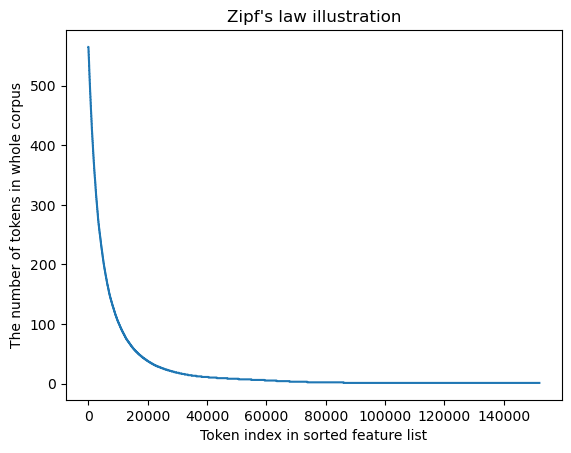

In [35]:
plt.plot(np.sort(s)[::-1][5000:])
plt.xlabel('Token index in sorted feature list')
plt.ylabel('The number of tokens in whole corpus')
plt.title("Zipf's law illustration")
plt.show()

#### What if binary coding chosen?

In [36]:
%%time

with open(f'reviews_Review_Label_razdel_spacy.df', 'rb') as file:
    data = dill.load(file)

print('Count vectorizing...')
cnt_vec = CountVectorizer(tokenizer=WhitespaceTokenizer().tokenize, binary=True)
X_train = cnt_vec.fit_transform(train.review)
X_test  = cnt_vec.transform(test.review)

print('Training logreg...')
clf = LogisticRegression(max_iter=200, n_jobs=-1, class_weight='balanced')
clf.fit(X_train, train.label)
pred = clf.predict(X_test)

print('Metrics:')
print(classification_report(test.label, pred))

Count vectorizing...
Training logreg...
Metrics:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      2979
           2       0.97      0.97      0.97     20742

    accuracy                           0.94     23721
   macro avg       0.87      0.88      0.87     23721
weighted avg       0.94      0.94      0.94     23721

Wall time: 49.4 s
